In [ ]:
# ~8GB
!wget https://dsci6015s25-midterm.s3.us-east-1.amazonaws.com/X_train-002.dat
!wget https://dsci6015s25-midterm.s3.us-east-1.amazonaws.com/X_test.dat
!wget https://dsci6015s25-midterm.s3.us-east-1.amazonaws.com/y_train.dat
!wget https://dsci6015s25-midterm.s3.us-east-1.amazonaws.com/y_test.dat

In [ ]:
!cp X_train-002.dat vMalConv/X_train.dat
!cp X_test.dat vMalConv/X_test.dat
!cp y_train.dat vMalConv/y_train.dat
!cp y_test.dat vMalConv/y_test.dat

In [1]:
!pip install -r requirements.txt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 97.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... one
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 816.3/816.3 kB 62.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.0/4.0 MB 139.4 MB/s eta 0:00:00
  Created wheel for lightgbm: filename=lightgbm-4.6.0-py3-none-linux_x86_64.whl size=2737779 sha256=f43c928bdc27b189cdbdea558b0c6291a32a452cd8840305450fd817cb27d895
  Stored in directory: /home/ec2-user/.cache/pip/wheels/bb/db/6d/7814aed03437129dc284a055c084f201b765deb54b6908efab
Successfully built lightgbm
  Attempting uninstall: setuptools
    Found existing installation: setuptools 75.8.0
    Uninstalling setuptools-75.8.0:
      Successfully uninstalled setuptools-75.8.0


In [1]:
!pip install git+https://github.com/PFGimenez/ember.git

  Cloning https://github.com/PFGimenez/ember.git to /tmp/pip-req-build-j_hsd__u
  Running command git clone --filter=blob:none --quiet https://github.com/PFGimenez/ember.git /tmp/pip-req-build-j_hsd__u
  Resolved https://github.com/PFGimenez/ember.git to commit 3b82fe63069884882e743af725d29cc2a67859f1
  Preparing metadata (setup.py) ... done


In [2]:
import ember
import numpy as np
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
import torch as nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
import time 
import os

In [5]:
# Read vectorized features from the data files
X_train, y_train, X_test, y_test = ember.read_vectorized_features("vMalConv/")

# Print the shapes to verify
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (800000, 2381)
y_train shape: (800000,)
X_test shape: (200000, 2381)
y_test shape: (200000,)


In [6]:
print("Filtering unlabeled data...")
labelrows = (y_train != -1)
X_train = X_train[labelrows]
y_train = y_train[labelrows]

print(f"After filtering, X_train shape: {X_train.shape}")
print(f"After filtering, y_train shape: {y_train.shape}")

Filtering unlabeled data...
After filtering, X_train shape: (600000, 2381)
After filtering, y_train shape: (600000,)


In [7]:
# Sample the dataset to speed up experiments
print("Sampling the dataset...")

# Set sample sizes
train_sample_size = 90000  # Adjust based on your computational resources
test_sample_size = 25000

# Sample training data, preserving class distribution
malware_indices = np.where(y_train == 1)[0]
benign_indices = np.where(y_train == 0)[0]

malware_ratio = len(malware_indices) / len(y_train)
malware_sample_size = int(train_sample_size * malware_ratio)
benign_sample_size = train_sample_size - malware_sample_size

print(f"Original class distribution: {malware_ratio:.4f} malware, {1-malware_ratio:.4f} benign")
print(f"Sampling {malware_sample_size} malware and {benign_sample_size} benign samples")

# Randomly sample indices
np.random.seed(42)  # For reproducibility
sampled_malware_indices = np.random.choice(malware_indices, size=malware_sample_size, replace=False)
sampled_benign_indices = np.random.choice(benign_indices, size=benign_sample_size, replace=False)

# Combine indices
sampled_indices = np.concatenate([sampled_malware_indices, sampled_benign_indices])
np.random.shuffle(sampled_indices)

# Create sampled training datasets
X_train = X_train[sampled_indices]
y_train = y_train[sampled_indices]

# Check test dataset for unlabeled entries
test_labelrows = (y_test != -1)
X_test = X_test[test_labelrows]
y_test = y_test[test_labelrows]

# Sample test data similarly
test_malware_indices = np.where(y_test == 1)[0]
test_benign_indices = np.where(y_test == 0)[0]

test_malware_ratio = len(test_malware_indices) / len(y_test)
test_malware_sample_size = int(test_sample_size * test_malware_ratio)
test_benign_sample_size = test_sample_size - test_malware_sample_size

sampled_test_malware = np.random.choice(test_malware_indices, size=test_malware_sample_size, replace=False)
sampled_test_benign = np.random.choice(test_benign_indices, size=test_benign_sample_size, replace=False)

sampled_test_indices = np.concatenate([sampled_test_malware, sampled_test_benign])
np.random.shuffle(sampled_test_indices)

X_test = X_test[sampled_test_indices]
y_test = y_test[sampled_test_indices]

# Print sampled dataset shapes
print(f"Sampled X_train shape: {X_train.shape}")
print(f"Sampled y_train shape: {y_train.shape}")
print(f"Sampled X_test shape: {X_test.shape}")
print(f"Sampled y_test shape: {y_test.shape}")

# Check final class distribution
sampled_malware_count = np.sum(y_train == 1)
sampled_benign_count = np.sum(y_train == 0)
sampled_ratio = sampled_malware_count / len(y_train)
print(f"Sampled class distribution: {sampled_ratio:.4f} malware, {1-sampled_ratio:.4f} benign")

Sampling the dataset...
Original class distribution: 0.5000 malware, 0.5000 benign
Sampling 45000 malware and 45000 benign samples
Sampled X_train shape: (90000, 2381)
Sampled y_train shape: (90000,)
Sampled X_test shape: (25000, 2381)
Sampled y_test shape: (25000,)
Sampled class distribution: 0.5000 malware, 0.5000 benign


In [8]:
from sklearn.preprocessing import StandardScaler

# Initialize the StandardScaler
print("Standardizing features...")
mms = StandardScaler()

# Partial fit in batches to avoid memory issues
for x in range(0, len(X_train), 100000):
    end_idx = min(x + 100000, len(X_train)) 
    mms.partial_fit(X_train[x:end_idx])
    print(f"Processed batch {x//100000 + 1}")

# Transform the training data
X_train = mms.transform(X_train)
print("Feature standardization complete!")

Standardizing features...
Processed batch 1
Feature standardization complete!


In [10]:
import joblib
# Save the fitted scaler to a file
joblib.dump(mms, "scaler.joblib")
print("Scaler saved as scaler.joblib")


Scaler saved as scaler.joblib


In [11]:
# Reshape to create appropriate format for the model
print("Reshaping data...")
X_train = np.reshape(X_train, (-1, 1, X_train.shape[1]))
y_train = np.reshape(y_train, (-1, 1, 1))
print(f"Reshaped X_train shape: {X_train.shape}")
print(f"Reshaped y_train shape: {y_train.shape}")

Reshaping data...
Reshaped X_train shape: (90000, 1, 2381)
Reshaped y_train shape: (90000, 1, 1)


In [16]:
import torch
import torch.nn as nn

class MalConv(nn.Module):
    def __init__(self, input_size=2381, hidden_size=128, output_dim=1):
        super(MalConv, self).__init__()
        
        # For EMBER feature vectors, we don't need an embedding layer
        # Instead, we'll use fully connected layers
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, output_dim)
        
        # Activation functions
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        # Remove the channel dimension (batch_size, 1, features) -> (batch_size, features)
        x = x.squeeze(1)
        
        # First layer
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        
        # Second layer
        x = self.fc2(x)
        x = self.relu(x)
        x = self.dropout(x)
        
        # Output layer
        x = self.fc3(x)
        x = self.sigmoid(x)
        
        return x

# Create an instance of the model
model = MalConv(input_size=X_train.shape[2])
print(model)

MalConv(
  (fc1): Linear(in_features=2381, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.5, inplace=False)
  (sigmoid): Sigmoid()
)


In [17]:
import torch as nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split

print("Preparing PyTorch datasets...")
# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)

# Split into training and validation sets
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(
    X_train_tensor, y_train_tensor, test_size=0.2, random_state=42
)

# Create TensorDatasets
train_dataset = TensorDataset(X_train_split, y_train_split)
val_dataset = TensorDataset(X_val_split, y_val_split)

# Create DataLoaders
batch_size = 128  # Adjust based on your GPU memory
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
print("DataLoaders created successfully!")

Preparing PyTorch datasets...
DataLoaders created successfully!


In [18]:
# Training loop

import time
import os
num_epochs = 20
print("Starting training...")
for epoch in range(num_epochs):
    start_time =time.time()
    model.train()
    running_loss = 0.0
    
    for i, (inputs, labels) in enumerate(train_loader):
        device = nn.device('cuda' if nn.cuda.is_available() else 'cpu')
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer = nn.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)
        # Zero the parameter gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(inputs)
        
        # Ensure labels have the same shape as outputs [batch_size, 1]
        if len(labels.shape) == 3:  # If shape is [batch_size, 1, 1]
            labels = labels.squeeze(2)  # Convert to [batch_size, 1]
        elif len(labels.shape) == 1:  # If shape is [batch_size]
            labels = labels.unsqueeze(1)  # Convert to [batch_size, 1]
        criterion = torch.nn.MSELoss()
        # Calculate loss
        loss = criterion(outputs, labels)
        
        # Backward pass and optimize
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
        # Print progress
        if (i+1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], Loss: {loss.item():.4f}')
    
    epoch_time = time.time() - start_time
    print(f'Epoch {epoch+1}, Training_Loss: {running_loss/len(train_loader):.4f}, Time: {epoch_time:.2f}s')
    
    # Validation step
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            
            # Ensure labels have the same shape as outputs
            if len(labels.shape) == 3:  # If shape is [batch_size, 1, 1]
                labels = labels.squeeze(2)  # Convert to [batch_size, 1]
            elif len(labels.shape) == 1:  # If shape is [batch_size]
                labels = labels.unsqueeze(1)  # Convert to [batch_size, 1]
            
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            
            # Calculate accuracy
            predicted = (outputs > 0.5).float()
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    val_accuracy = 100 * correct / total
    print(f'Validation_Loss: {val_loss/len(val_loader):.4f}, Validation_Accuracy: {val_accuracy:.2f}%')
    
    # Save checkpoint every 5 epochs or at the end
    save_dir = '/home/ec2-user/SageMaker'
    if (epoch + 1) % 5 == 0 or epoch == num_epochs - 1:
        checkpoint_path = os.path.join(save_dir, f'model_epoch_{epoch+1}.pt')
        torch.save({
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss.item(),
            'accuracy': val_accuracy,
            'scaler': mms,
        }, checkpoint_path)
        print(f'Model checkpoint saved to {checkpoint_path}')

print("Training complete!")


Starting training...
Epoch [1/20], Step [10/563], Loss: 0.1737
Epoch [1/20], Step [20/563], Loss: 0.1432
Epoch [1/20], Step [30/563], Loss: 0.1446
Epoch [1/20], Step [40/563], Loss: 0.1231
Epoch [1/20], Step [50/563], Loss: 0.1101
Epoch [1/20], Step [60/563], Loss: 0.1259
Epoch [1/20], Step [70/563], Loss: 0.0915
Epoch [1/20], Step [80/563], Loss: 0.1329
Epoch [1/20], Step [90/563], Loss: 0.1095
Epoch [1/20], Step [100/563], Loss: 0.1064
Epoch [1/20], Step [110/563], Loss: 0.0794
Epoch [1/20], Step [120/563], Loss: 0.1160
Epoch [1/20], Step [130/563], Loss: 0.1092
Epoch [1/20], Step [140/563], Loss: 0.0635
Epoch [1/20], Step [150/563], Loss: 0.0831
Epoch [1/20], Step [160/563], Loss: 0.0792
Epoch [1/20], Step [170/563], Loss: 0.0967
Epoch [1/20], Step [180/563], Loss: 0.0787
Epoch [1/20], Step [190/563], Loss: 0.0908
Epoch [1/20], Step [200/563], Loss: 0.0911
Epoch [1/20], Step [210/563], Loss: 0.1067
Epoch [1/20], Step [220/563], Loss: 0.1050
Epoch [1/20], Step [230/563], Loss: 0.0904

Matplotlib is building the font cache; this may take a moment.


Evaluating model on test set...
Test Accuracy: 0.9100
Precision: 0.8994
Recall: 0.9233
F1 Score: 0.9112


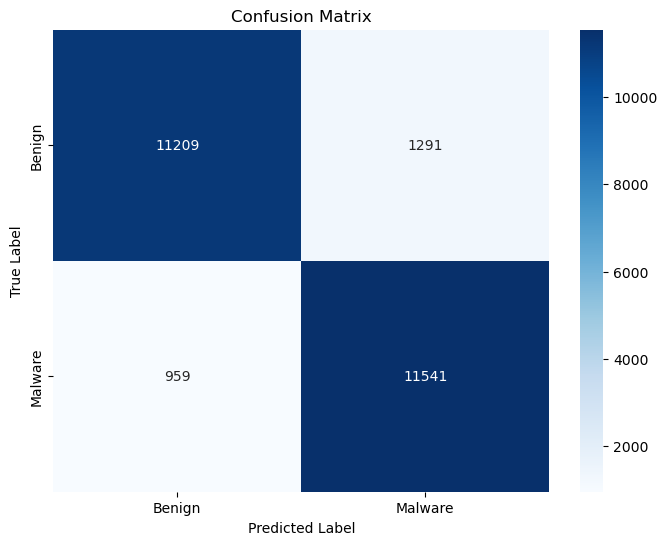

Final model saved to /home/ec2-user/SageMaker/malconv_final.pt


In [19]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Transform the test data
X_test = mms.transform(X_test)
X_test = np.reshape(X_test, (-1, 1, X_test.shape[1]))

# Convert test data to PyTorch tensors
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

# Create a test dataset and dataloader
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Ensure the model is in evaluation mode
model.eval()

# Lists to store model predictions and actual labels
predictions = []
actual_labels = []

print("Evaluating model on test set...")
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        # Forward pass
        outputs = model(inputs)
        
        # Ensure labels have the same shape as outputs
        if len(labels.shape) == 3:  # If shape is [batch_size, 1, 1]
            labels = labels.squeeze(2)  # Convert to [batch_size, 1]
        elif len(labels.shape) == 1:  # If shape is [batch_size]
            labels = labels.unsqueeze(1)  # Convert to [batch_size, 1]
        
        # Convert probabilities to binary predictions
        predicted = (outputs > 0.5).float()
        
        # Store predictions and labels
        predictions.extend(predicted.cpu().numpy())
        actual_labels.extend(labels.cpu().numpy())

# Convert to flat arrays
predictions = np.array(predictions).flatten()
actual_labels = np.array(actual_labels).flatten()

# Compute metrics
accuracy = accuracy_score(actual_labels, predictions)
precision = precision_score(actual_labels, predictions)
recall = recall_score(actual_labels, predictions)
f1 = f1_score(actual_labels, predictions)
conf_matrix = confusion_matrix(actual_labels, predictions)

print(f'Test Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
           xticklabels=['Benign', 'Malware'],
           yticklabels=['Benign', 'Malware'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Save the final model for deployment
final_model_path = os.path.join(save_dir, 'malconv_final.pt')
torch.save({
    'model_state_dict': model.state_dict(),
    'scaler': mms,
    'input_size': X_train.shape[2],
    'hidden_size': 128,
    'output_dim': 1,
}, final_model_path)

print(f'Final model saved to {final_model_path}')

In [20]:
torch.save(model.state_dict(), "deployment/model_final_2.pt")

In [26]:
import tarfile

tarball_name = "deployment/model_final_2.tar.gz"
with tarfile.open(tarball_name, "w:gz") as tar:
    tar.add("deployment/model_final_2.pt", arcname="model_final_2.pt")
    tar.add("deployment/serve.py", arcname="serve.py")
    tar.add("scaler.joblib", arcname="scaler.joblib")

print(f"Tarball '{tarball_name}' created successfully!")

Tarball 'deployment/model_final_2.tar.gz' created successfully!


In [29]:
!tar -tvf deployment/model_final_2.tar.gz

-rw-rw-r-- ec2-user/ec2-user 1288836 2025-03-24 14:18 model_final_2.pt
-rw-rw-r-- ec2-user/ec2-user    2337 2025-03-23 04:47 serve.py
-rw-rw-r-- ec2-user/ec2-user   57743 2025-03-24 14:11 scaler.joblib


In [ ]:
#s3_Bucket
s3_bucket = "sagemaker-us-east-1-548693114540"
s3_prefix = "Malware-detection-v1"
model_file = "model_.tar.gz"  # Your local model file

# Upload the model to S3
s3 = boto3.client("s3")
s3.upload_file(model_file, s3_bucket, f"{s3_prefix}/model.tar.gz")

print(f"Model uploaded to s3://{s3_bucket}/{s3_prefix}/model.tar.gz")